Training on dataset D1: Data shape (2500, 32, 32, 3)
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 408ms/step
Weights saved to trained_weights.pkl
Evaluated on dataset D1: Accuracy = 0.8920
Training on dataset D2: Data shape (2500, 32, 32, 3)
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 445ms/step
Weights saved to trained_weights.pkl
Evaluated on dataset D1: Accuracy = 0.8020
Evaluated on dataset D2: Accuracy = 0.8884
Training on dataset D3: Data shape (2500, 32, 32, 3)
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 430ms/step
Weights saved to trained_weights.pkl
Evaluated on dataset D1: Accuracy = 0.7232
Evaluated on dataset D2: Accuracy = 0.8160
Evaluated on dataset D3: Accuracy = 0.8680
Training on dataset D4: Data shape (2500, 32, 32, 3)
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 408ms/step
Weights saved to trained_weights.pkl
Evaluated on dataset D1: Accuracy = 0.6508
Evaluated on dataset D2: Accuracy = 0.7672
Evaluated on dataset D3: Accuracy = 0.7748
Evaluated on dataset D4: Accuracy = 0.8828
Training on dataset D5: Data shape (2500, 

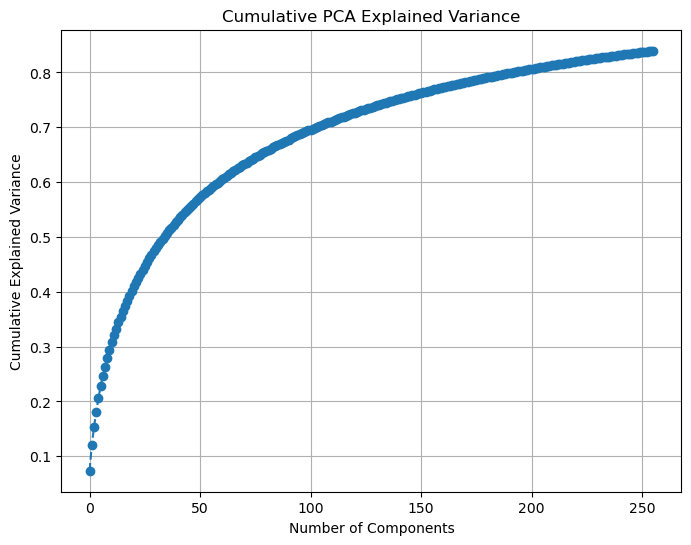

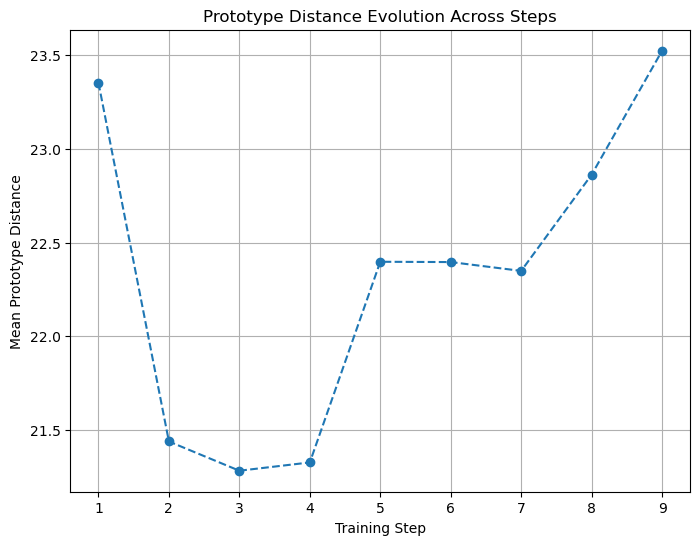

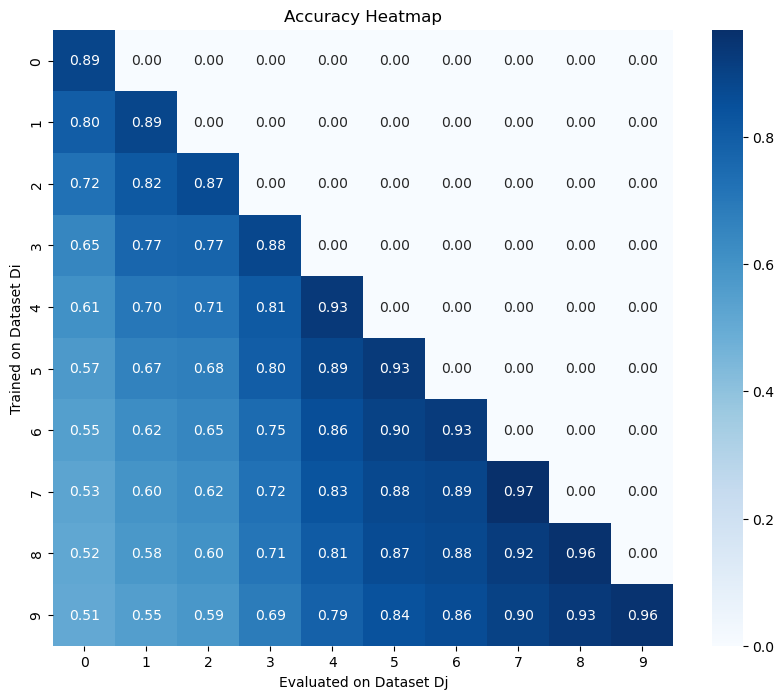

Accuracy matrix:
[[0.892  0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.802  0.8884 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.7232 0.816  0.868  0.     0.     0.     0.     0.     0.     0.    ]
 [0.6508 0.7672 0.7748 0.8828 0.     0.     0.     0.     0.     0.    ]
 [0.6084 0.7016 0.7128 0.8124 0.9316 0.     0.     0.     0.     0.    ]
 [0.5744 0.6656 0.6772 0.7992 0.8884 0.9304 0.     0.     0.     0.    ]
 [0.5508 0.6244 0.6484 0.746  0.8588 0.9012 0.9268 0.     0.     0.    ]
 [0.528  0.596  0.6216 0.724  0.8328 0.878  0.892  0.9688 0.     0.    ]
 [0.518  0.5808 0.6036 0.7092 0.8068 0.8684 0.8796 0.9208 0.9596 0.    ]
 [0.51   0.5544 0.586  0.6884 0.7856 0.842  0.8632 0.902  0.9336 0.9564]]


In [16]:
import tensorflow as tf
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
import pickle

# Load previous weights (prototypes and PCA components)
def load_weights(filename: str = "trained_weights.pkl"):
    """Load classifier prototypes and PCA components."""
    with open(filename, "rb") as f:
        weights = pickle.load(f)
    return weights

def save_weights(classifier, feature_reducer, filename: str = "weights.pkl"):
    """Save classifier prototypes and PCA components."""
    weights = {
        "prototypes": classifier.prototypes,
        "pca_components": feature_reducer.pca.components_,
        "pca_mean": feature_reducer.pca.mean_
    }
    with open(filename, "wb") as f:
        pickle.dump(weights, f)
    print(f"Weights saved to {filename}")
# Visualization Functions
def plot_pca_variance(feature_reducer):
    """Plot the variance explained by each principal component."""
    explained_variance = feature_reducer.pca.explained_variance_ratio_
    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
    plt.title('Cumulative PCA Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

def plot_prototype_distances(prototypes_list):
    """Plot distances between prototypes across training steps."""
    num_steps = len(prototypes_list)
    distances = [
        cdist(prototypes_list[i], prototypes_list[i + 1], metric='euclidean').mean()
        for i in range(num_steps - 1)
    ]
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_steps), distances, marker='o', linestyle='--')
    plt.title('Prototype Distance Evolution Across Steps')
    plt.xlabel('Training Step')
    plt.ylabel('Mean Prototype Distance')
    plt.grid(True)
    plt.show()

def plot_accuracy_heatmap(accuracy_matrix):
    """Plot a heatmap of the accuracy matrix."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(accuracy_matrix, annot=True, fmt=".2f", cmap="Blues")
    plt.title('Accuracy Heatmap')
    plt.xlabel('Evaluated on Dataset Dj')
    plt.ylabel('Trained on Dataset Di')
    plt.show()

# Step 1: Load the dataset
def load_dataset(filepath: str):
    """Loads a dataset from a given file path."""
    t = torch.load(filepath)
    data, targets = t['data'], t.get('targets')  # Targets may be None for unlabeled data
    return data, targets

# Step 2: Feature Extraction with ResNet50
class ResNet50FeatureExtractor:
    def __init__(self, input_shape=(112, 112, 3)):
        # Load ResNet50 without the top classification layer
        self.model = tf.keras.applications.ResNet50(
            weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape
        )

    def preprocess(self, data: np.ndarray):
        """Preprocess raw image data to match ResNet50 input requirements."""
        data = data.astype(np.float32)
        resized_data = np.array([tf.image.resize(img, (112, 112)).numpy() for img in data])
        preprocessed_data = tf.keras.applications.resnet50.preprocess_input(resized_data)
        return preprocessed_data

    def extract(self, data: np.ndarray):
        """Extract features using ResNet50."""
        preprocessed_data = self.preprocess(data)
        features = self.model.predict(preprocessed_data, batch_size=32, verbose=1)
        return features

# Step 3: Dimensionality Reduction
class FeatureReducer:
    def __init__(self, n_components=256):
        self.pca = PCA(n_components=n_components)

    def fit_transform(self, data: np.ndarray):
        return self.pca.fit_transform(data)

    def transform(self, data: np.ndarray):
        return self.pca.transform(data)

# Step 4: LwP Classifier with Regularization and Domain Adaptation
class LwPClassifier:
    def __init__(self, num_classes: int, lambda_reg=0.1, lambda_adapt=0.1):
        self.num_classes = num_classes
        self.prototypes = None
        self.lambda_reg = lambda_reg  # Regularization strength
        self.lambda_adapt = lambda_adapt  # Adaptation strength for domain shift

    def fit(self, data: np.ndarray, labels: np.ndarray):
        """Initialize prototypes based on labeled data.""" 
        self.prototypes = []
        for cls in range(self.num_classes):
            cls_data = data[labels == cls]
            if len(cls_data) > 0:
                cls_prototype = cls_data.mean(axis=0)
                self.prototypes.append(cls_prototype)
        self.prototypes = np.array(self.prototypes)

    def predict(self, data: np.ndarray):
        """Predict labels for the given data."""
        distances = cdist(data, self.prototypes)
        return np.argmin(distances, axis=1)

    def update(self, data: np.ndarray, pseudo_labels: np.ndarray, alpha=0.7):
        """Update prototypes using pseudo-labeled data with regularization and domain adaptation."""
        for cls in range(self.num_classes):
            cls_data = data[pseudo_labels == cls]
            if len(cls_data) > 0:
                cls_mean = cls_data.mean(axis=0)
                # Regularized update
                self.prototypes[cls] = (alpha * self.prototypes[cls] + (1 - alpha) * cls_mean) - \
                                       self.lambda_reg * (self.prototypes[cls] - cls_mean)

    def domain_adaptation(self, old_prototypes, new_prototypes, alpha=0.5):
        """Adapt the prototypes to minimize domain shift using internal distributions."""
        adapted_prototypes = []
        for old, new in zip(old_prototypes, new_prototypes):
            adapted_proto = alpha * old + (1 - alpha) * new
            adapted_prototypes.append(adapted_proto)
        return np.array(adapted_prototypes)

# Step 5: LCAuCID Classifier
class LCAuCIDClassifier(LwPClassifier):
    def __init__(self, num_classes: int, lambda_reg=0.1, lambda_adapt=0.1):
        super().__init__(num_classes, lambda_reg, lambda_adapt)

    def update(self, data: np.ndarray, pseudo_labels: np.ndarray, alpha=0.7):
        """Update prototypes with domain adaptation and regularization."""
        super().update(data, pseudo_labels, alpha)
        # Perform domain adaptation to reduce domain shift
        self.prototypes = self.domain_adaptation(self.prototypes, self.prototypes, self.lambda_adapt)

# Train and evaluate function
# Step 2: Modify the train_and_evaluate function to collect metrics for plotting
# Train and evaluate function
def train_and_evaluate(train_files: list, eval_files: list, num_classes=10):
    n = len(train_files)  # Number of datasets
    accuracies = np.zeros((n, n))  # Accuracy matrix (n x n): Train on Di, evaluate on Dj
    
    feature_extractor = ResNet50FeatureExtractor()
    feature_reducer = FeatureReducer()
    classifier = LCAuCIDClassifier(num_classes=num_classes)
    
    # Initial load of weights
    weights = load_weights("trained_weights.pkl")
    classifier.prototypes = weights["prototypes"]
    feature_reducer.pca.components_ = weights["pca_components"]
    feature_reducer.pca.mean_ = weights["pca_mean"]

    reduced_features_list = []
    targets_list = []
    prototypes_list = []  # Collect prototypes after each training step

    for i in range(n):
        data, targets = load_dataset(train_files[i])
        print(f"Training on dataset D{i+1}: Data shape {data.shape}")
        
        features = feature_extractor.extract(data)
        reduced_features = feature_reducer.fit_transform(features) if i == 0 else feature_reducer.transform(features)
        pseudo_labels = classifier.predict(reduced_features) if targets is None else np.array(targets)
        classifier.update(reduced_features, pseudo_labels)
        
        reduced_features_list.append(reduced_features)
        targets_list.append(targets if targets is not None else pseudo_labels)
        prototypes_list.append(classifier.prototypes.copy())
        
        # Save updated weights
        save_weights(classifier, feature_reducer, filename="trained_weights.pkl")
        
        # Reload updated weights for the next iteration
        # if i > 1:  # Skip reloading after the last dataset
        #     weights = load_weights("trained_weights.pkl")
        #     classifier.prototypes = weights["prototypes"]
        #     feature_reducer.pca.components_ = weights["pca_components"]
        #     feature_reducer.pca.mean_ = weights["pca_mean"]

        for j in range(i + 1):
            eval_features = reduced_features_list[j]
            eval_targets = targets_list[j]
            predictions = classifier.predict(eval_features)
            accuracies[i, j] = accuracy_score(eval_targets, predictions)
            print(f"Evaluated on dataset D{j+1}: Accuracy = {accuracies[i, j]:.4f}")
    
    # Plot after training
    plot_pca_variance(feature_reducer)
    plot_prototype_distances(prototypes_list)
    plot_accuracy_heatmap(accuracies)
    
    return accuracies


# Example usage
train_files = [f"dataset/part_two_dataset/train_data/{i}_train_data.tar.pth" for i in range(1, 11)]
eval_files = [f"dataset/part_two_dataset/eval_data/{i}_eval_data.tar.pth" for i in range(1, 11)]
accuracies = train_and_evaluate(train_files, eval_files)
print("Accuracy matrix:")
print(accuracies)


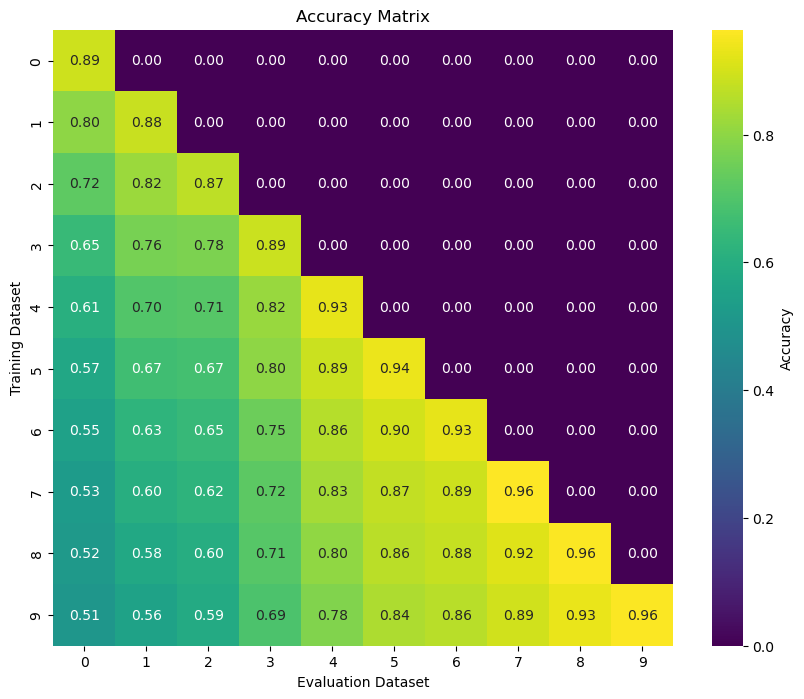

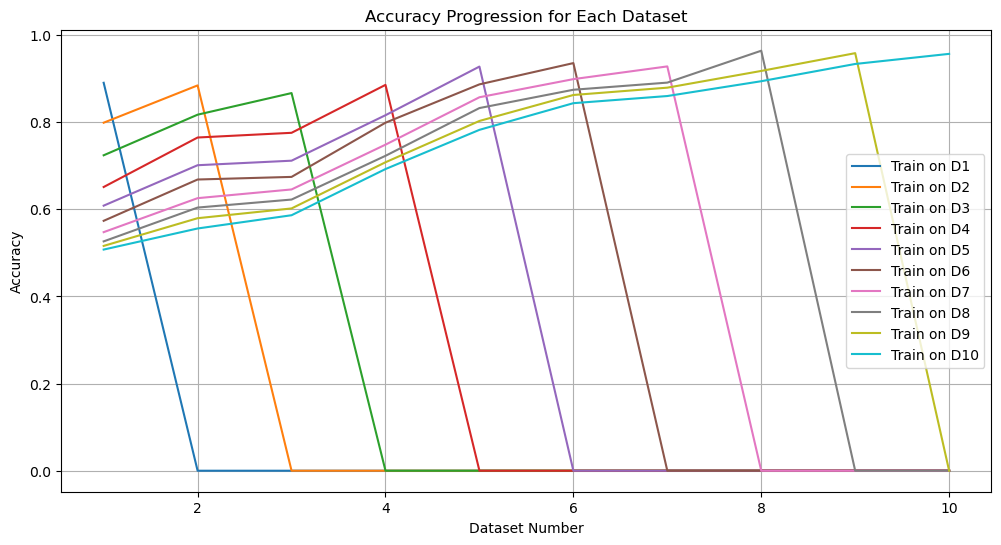

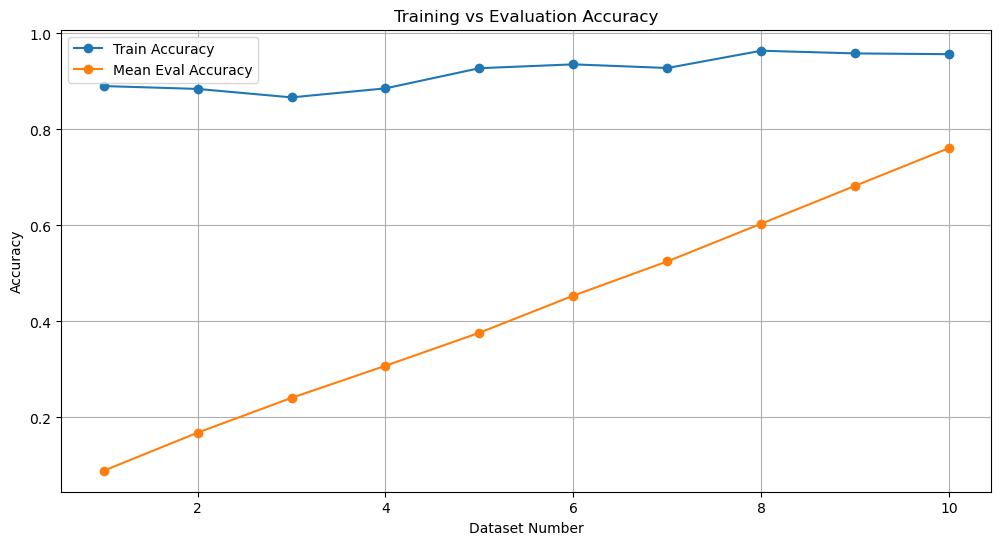

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Accuracy Matrix Heatmap
def plot_accuracy_matrix(accuracies):
    plt.figure(figsize=(10, 8))
    sns.heatmap(accuracies, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Accuracy'})
    plt.title("Accuracy Matrix")
    plt.xlabel("Evaluation Dataset")
    plt.ylabel("Training Dataset")
    plt.show()

# 2. Accuracy Progression per Dataset
def plot_accuracy_progression(accuracies):
    n = accuracies.shape[0]
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.plot(range(1, n + 1), accuracies[i], label=f"Train on D{i+1}")
    plt.title("Accuracy Progression for Each Dataset")
    plt.xlabel("Dataset Number")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# 4. Prototype Distance Evolution
def plot_prototype_distances(prototypes_list):
    distances = []
    for i in range(len(prototypes_list) - 1):
        dist = np.linalg.norm(prototypes_list[i] - prototypes_list[i + 1], axis=1)
        distances.append(dist)
    distances = np.array(distances).T

    plt.figure(figsize=(10, 6))
    for cls in range(distances.shape[0]):
        plt.plot(distances[cls], label=f"Class {cls}")
    plt.title("Prototype Distance Evolution")
    plt.xlabel("Training Step")
    plt.ylabel("Distance Between Prototypes")
    plt.legend()
    plt.grid()
    plt.show()

# 5. Evaluation Comparison
def plot_evaluation_comparison(accuracies):
    train_accuracies = np.diagonal(accuracies)
    mean_eval_accuracies = accuracies.mean(axis=1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
    plt.plot(range(1, len(mean_eval_accuracies) + 1), mean_eval_accuracies, marker='o', label="Mean Eval Accuracy")
    plt.title("Training vs Evaluation Accuracy")
    plt.xlabel("Dataset Number")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Example Visualization Calls
plot_accuracy_matrix(accuracies)  # Plot the accuracy matrix
plot_accuracy_progression(accuracies)  # Plot accuracy progression
plot_evaluation_comparison(accuracies)  # Training vs Evaluation accuracy comparison
